<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
!pip install --upgrade tensorflow_probability
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

print(tf.version.VERSION)
print(tfp.python.version.__version__)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
     |████████████████████████████████| 2.5MB 6.6MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0 which is incompatible.
ERROR: gym 0.15.4 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: cloudpickle 1.2.2
    Uninstalling cloudpickle-1.2.2:
      Successfully uninstalled cloudpickle-1.2.2
  Found existing installation: tensorflow-probability 0.7.0
    Uninstalling tensorflow-probability-0.7.0:
      Successfully uninstalled tensorflow-probability-0.7.0


2.1.0-rc1
0.8.0
/device:GPU:0


In [2]:
input_shape=[28,28,1]
label_shape=[10]
def to_ds(tpl):
  img, lbl = tpl
  return tf.data.Dataset.from_tensor_slices(tpl).map(
      lambda img, lbl: (tf.cast(tf.reshape(img, [28,28,1]), 'float32') / 255., tf.one_hot(lbl, 10)) 
  ).map(
      lambda img, lbl: ((img, lbl), (img,lbl))
  ).batch(1000)

train_ds, test_ds = map(
    to_ds,
    tf.keras.datasets.mnist.load_data())

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
train_ds

<BatchDataset shapes: (((None, 28, 28, 1), (None, 10)), ((None, 28, 28, 1), (None, 10))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32))>

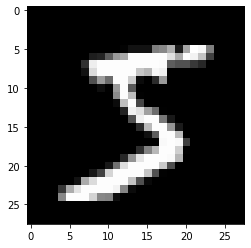

5 : tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [4]:
(img, lbl), _ = next(iter(train_ds))
plt.imshow(img[0,:,:,0], cmap='gray')
plt.show()
print(np.argmax(lbl[0]),":" ,lbl[0])

In [0]:
def encoder(z_size, latent_size=10, base_depth=4):
  prior = tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=tf.zeros(z_size), scale=1),
          reinterpreted_batch_ndims=1)
  img2vec = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_size * 4, activation='relu'),
    tf.keras.layers.Dense(latent_size * 2, activation='relu'),
    tf.keras.layers.Dense(latent_size, activation='softmax')
  ])
  lbl2vec = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[latent_size]),
  ])
  
  c = tf.keras.layers.concatenate([img2vec.output, lbl2vec.output])
  
  latent_z = tf.keras.Sequential([
      tf.keras.layers.Dense(latent_size, activation='relu'),
      tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(z_size)),
      tfp.layers.MultivariateNormalTriL(
        z_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior))
  ])
  
  return tf.keras.Model(inputs=[img2vec.input, lbl2vec.input], outputs=latent_z(c))

In [0]:
def decoder(z_size, latent_size=10, base_depth=4):
  img_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(latent_size, activation='relu'),
    tf.keras.layers.Dense(latent_size * 2, activation='relu'),
    tf.keras.layers.Dense(latent_size * 4, activation='relu'),
    tf.keras.layers.Dense(tfp.layers.IndependentBernoulli.params_size(input_shape)),
    tfp.layers.IndependentBernoulli(input_shape, tfp.distributions.Bernoulli.logits),
  ])
  label_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(latent_size, activation='relu'),
    tf.keras.layers.Dense(tfp.layers.OneHotCategorical.params_size(label_shape[0])),
    tfp.layers.OneHotCategorical(label_shape)
  ])
  latent_z = tf.keras.layers.Input(shape=[z_size])
  return tf.keras.Model(inputs=[latent_z], outputs=[img_decoder(latent_z), label_decoder(latent_z)])

In [0]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

def vae(latent_size, learning_rate=1e-3):
  enc = encoder(latent_size)
  dec = decoder(latent_size)

  model = tf.keras.Model(inputs=enc.inputs, outputs=dec(enc.outputs))
  model.encoder = enc
  model.decoder = dec
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=negloglik)
  return model


In [8]:
m = vae(10, learning_rate=1e-3)
res = m.fit(train_ds, epochs=100, validation_data=test_ds)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Train for 60 steps, validate for 10 steps
Epoch 1/100
60/60 [==============================] - 9s 157ms/step - loss: 440.3201 - model_1_loss: 433.2725 - model_1_1_loss: 2.3584 - val_loss: 263.6648 - val_model_1_loss: 255.9529 - val_model_1_1_loss: 2.3343
Epoch 2/100
60/60 [==============================] - 6s 94ms/step - loss: 229.6669 - model_1_loss: 221.6770 - model_1_1_loss: 2.3122 - val_loss: 218.7243 - val_model_1_loss: 211.2040 - val_model_1_1_loss: 2.3001
Epoch 3/100
60/60 [==============================] - 6s 92ms/step - loss: 217.1160 - model_1_loss: 210.1834 - model_1_1_loss: 2.2954 - val_loss: 215.2358 - val_model_1_loss: 208.8238 - val_model_1_1_loss: 2.2901
Epoch 4/100
60/60 [==============================] - 6s 92ms/step - loss: 214.1778 - model_1_loss: 208.1405 - model_1_1_loss: 2.2916 - val_loss: 211.8840 - val_model_1_loss: 206.1251 - val_model_1_1_loss: 2.2881
Epoch 5/100
60/60 [===

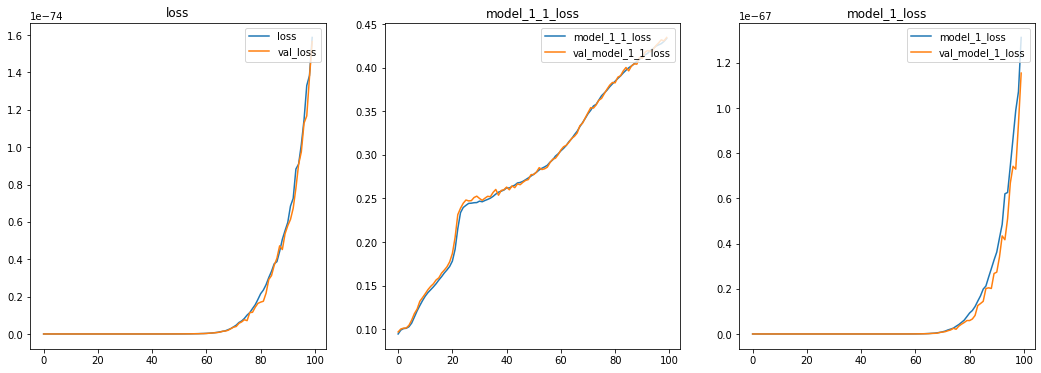

In [9]:
from itertools import groupby
key = lambda x: x[0][0] == 'v' and x[0][4:] or x[0]
s = sorted(res.history.items(), key=key)
points = groupby(s, key)
f, axs = plt.subplots(1, 3, figsize=(18,6)
                      )
for (g, history), ax in zip(points, axs):
  for k, v in history:
    ax.plot(*zip(*enumerate(np.exp(np.array([0]) - v))), label=k)
  ax.legend(loc='upper right')
  ax.set_title(g)
plt.show()

p(x , y | z) => p(x | z , y)

p(a|b)p(b) = p(b|a)p(a) = p(a,b)

p(x|z,y) = p(x,y|z) / p(y|z)

In [10]:
list(map(lambda x: x.shape, m.weights))

[TensorShape([784, 40]),
 TensorShape([40]),
 TensorShape([40, 20]),
 TensorShape([20]),
 TensorShape([20, 10]),
 TensorShape([10]),
 TensorShape([20, 10]),
 TensorShape([10]),
 TensorShape([10, 65]),
 TensorShape([65]),
 TensorShape([10, 10]),
 TensorShape([10]),
 TensorShape([10, 20]),
 TensorShape([20]),
 TensorShape([20, 40]),
 TensorShape([40]),
 TensorShape([40, 784]),
 TensorShape([784]),
 TensorShape([10, 10]),
 TensorShape([10]),
 TensorShape([10, 10]),
 TensorShape([10])]

In [11]:
m.encoder.layers

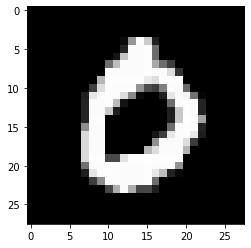

tf.Tensor([[-0.69 -0.01 -0.37  0.54  0.59 -0.43  0.39  0.39  0.46 -0.48]], shape=(1, 10), dtype=float32)
tf.Tensor([[0.9  0.56 0.86 0.94 0.9  0.97 0.96 0.98 0.94 0.97]], shape=(1, 10), dtype=float32)


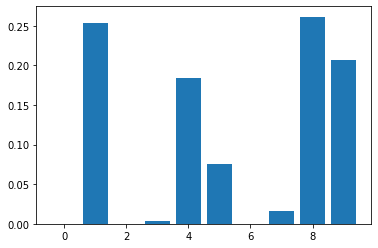

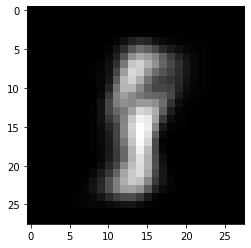

In [26]:
img0 = np.zeros([1,28,28,1])
img1 = next(iter(test_ds))[0][0][3:4]
plt.imshow(img1[0,:,:,0], cmap='gray')
plt.show()
lbl2 = np.eye(10)[np.array([7])]
lbl0 = np.zeros([1,10])
x = m.encoder((img0,lbl2))
print(x.mean())
print(x.stddev())
img, lbl = m.decoder(x)
plt.bar(range(10), lbl.mean()[0])
plt.show()
plt.imshow(img.mean()[0,:,:,0], cmap='gray')
plt.show()

In [20]:
np.set_printoptions(precision=2,suppress=True)
adhoc = tf.keras.Model(inputs=m.encoder.input, outputs=m.encoder.layers[7].output)
adhoc((next(iter(test_ds))[0][0][3:4], lbl2))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0.1 , 0.33, 0.15, 0.  , 0.09, 0.  , 0.04, 0.19, 0.07, 0.02, 1.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)>

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
